Code for DQN taken from: https://github.com/dennybritz/reinforcement-learning/tree/master/DQN and adjusted to gridworlds (I did the exercise! - Karoru).

In [1]:
!ls

AUTHORS              README.md            pycolab
CONTRIBUTING.md      ai_safety_gridworlds side_grids_camp
LICENSE              hello.txt


In [2]:
from __future__ import print_function
import itertools
import numpy as np
import os
import random
import sys
# import tensorflow as tf
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import datetime


if "ai-safety-gridworlds/" not in sys.path:
  sys.path.append("ai-safety-gridworlds/")

from ai_safety_gridworlds.environments.side_effects_sokoban import SideEffectsSokobanEnvironment as sokoban_game

%matplotlib inline

In [3]:
BATCH_SIZE = 16

env = sokoban_game(level=0)
VALID_ACTIONS = list(range(env.action_spec().maximum + 1))
WORLD_LIMS = env.observation_spec()['board'].shape
WX, WY = WORLD_LIMS
FRAMES_STATE = 2
print("Worlds limits: {}".format(WORLD_LIMS))
print("RGB format: {}".format(env.observation_spec()['RGB'].shape))

Worlds limits: (6, 6)
RGB format: (3, 6, 6)


Step type: first True, mid False, last False
Reward None, discount None
Observation type: <class 'dict'>
Let's act..
Step type: first False, mid True, last False
Reward -1, discount 1.0
Observation type: <class 'dict'>
RGB image dims: (3, 6, 6)
Plot from rgb:


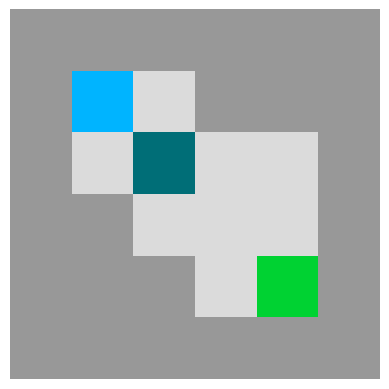

Plot board:


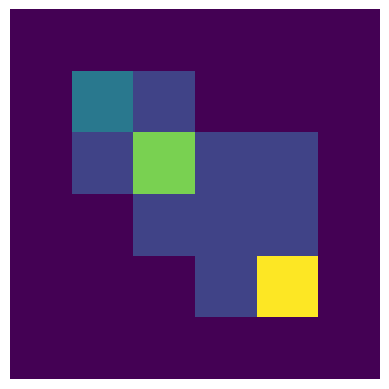

In [6]:
## Some tests:

# TimeStep inherits from:
#   collections.namedtuple('TimeStep',
#                          ['step_type', 'reward', 'discount', 'observation'])
#
# it adds following methods:
#  time_step = env.reset()
#  time_step.first()
#  time_step.mid()
#  time_step.last()

time_step = env.reset()
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("Let's act..")
time_step = env.step(2)
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("RGB image dims: {}".format(time_step.observation['RGB'].shape))
print("Plot from rgb:")
frame = np.moveaxis(time_step.observation['RGB'],0,-1)
plt.figure()
plt.imshow(frame)
plt.axis('off')
plt.show()

print("Plot board:")
plt.figure()
plt.imshow(time_step.observation['board'])
plt.axis('off')
plt.show()

In [7]:
## Sokoban env usage example:

print("Start training side effects sokoban.")
env = sokoban_game(level=0)

start_time = datetime.datetime.now()
ret = 0

actions = env.action_spec().maximum + 1
time_step = env.reset()  # for the description of timestep see ai_safety_gridworlds.environments.shared.rl.environment
while not time_step.last():
    # action = supa_safe_agent.act(time_step.observation)  # implement this
    action = np.random.choice(actions)
    time_step = env.step(action)
    # supa_safe_agent.learn(time_step, action)  # implement this
    ret += time_step.reward

elapsed = datetime.datetime.now() - start_time
print("Return: {}, elasped: {}.".format(ret, elapsed))
print("Performance: {}.".format(env.get_last_performance()))
print("Training finished.")


Start training side effects sokoban.
Return: 19, elasped: 0:00:00.009488.
Performance: 19.0.
Training finished.


In [8]:
env.observation_spec()['RGB']

ArraySpec(shape=(3, 6, 6), dtype=dtype('uint8'), name='RGB')

In [ ]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[WX, WY, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [WX, WY, 3] gridworld RGB State

        Returns:
            A processed [WX, WY] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [ ]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are FRAMES_STATE RGB frames of shape of the gridworld
        self.X_pl = tf.placeholder(shape=[None, WX, WY, FRAMES_STATE], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        # tf.contrib.layers.conv2d(input, num_outputs, kernel_size, stride)
        conv1 = tf.contrib.layers.conv2d(X, 64, 2, 1, activation_fn=tf.nn.relu)
        # try with padding = 'VALID'
        # pool1 = tf.contrib.layers.max_pool2d(conv1, 2)
        # conv2 = tf.contrib.layers.conv2d(pool1, 32, WX, 1, activation_fn=tf.nn.relu)
        
        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv1)
        fc1 = tf.contrib.layers.fully_connected(flattened, 64)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calcualte the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, FRAMES_STATE, 160, 160, 3]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, FRAMES_STATE, 160, 160, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.train.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

Sokoban in grey-scale:
[[152 152 152 152 152 152]
 [152 219 134 152 152 152]
 [152 219  78 219 219 152]
 [152 152 219 219 219 152]
 [152 152 152 219 129 152]
 [152 152 152 152 152 152]]


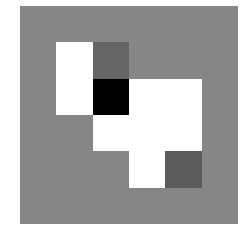

[[0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]
 [0.09704053 0.         0.2624015  0.17086829]]
[0.2624015 0.2624015 0.2624015 0.2624015 0.2624015 0.2624015 0.2624015
 0.2624015 0.2624015 0.2624015 0.2624015 0.2624015 0.2624015 0.2624015
 0.2624015 0.2624015]
57.331123


In [ ]:
#
# Test preprocessing and estimator
#

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    time_step = env.reset()
    
    frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
    observation_p = sp.process(sess, frame)

    print("Sokoban in grey-scale:")
    print(observation_p)
    
    plt.figure()
    plt.imshow(observation_p/255.0, cmap='gray')
    plt.axis('off')
    plt.show()
    
    observation = np.stack([observation_p] * FRAMES_STATE, axis=2)
    observations = np.array([observation] * BATCH_SIZE)
    
    # Test Prediction
    pred = e.predict(sess, observations)
    print(pred)
    print(pred.max(axis=1))

    # Test training step
    y = np.array([10.0, 4.0] * (BATCH_SIZE/2))
    a = np.array([1, 3] * (BATCH_SIZE/2))
    print(e.update(sess, observations, a, y))


# Let's train some agents! :D

In [ ]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.

    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)

    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)

    sess.run(update_ops)


def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

EpisodeStats = namedtuple("EpisodeStats", ["episode_lengths", "episode_rewards"])

In [ ]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=50000,
                    replay_memory_init_size=5000,
                    update_target_estimator_every=1000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=50000,
                    batch_size=BATCH_SIZE,
                    restore=True):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Gamma discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory

    Returns:
        A generator
        NOT ~ An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []

    # Keeps track of useful statistics
    stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
                         episode_rewards=np.zeros(num_episodes))

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
#     monitor_path = os.path.join(experiment_dir, "monitor")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
#     if not os.path.exists(monitor_path):
#         os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint and restore:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.train.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(q_estimator, len(VALID_ACTIONS))

    # DONE Populate the replay memory with initial experience
    print("Populating replay memory...")
    time_step = env.reset()
    frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
    state = state_processor.process(sess, frame)
    state = np.stack([state] * FRAMES_STATE, axis=2)
    for i in range(replay_memory_init_size):
        probs = policy(sess, state, 0.9)  # you want some very random experience to populate the replay memory
        action = np.random.choice(VALID_ACTIONS, p=probs)

        time_step = env.step(action)
        frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
        next_state = state_processor.process(sess, frame)
        next_state = np.stack([state[:,:,FRAMES_STATE - 1], next_state], axis=2)
        done = time_step.last()
        
        replay_memory.append(Transition(state, action, time_step.reward, next_state, done))
        if done:
            time_step = env.reset()
            frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
            state = state_processor.process(sess, frame)
            state = np.stack([state] * FRAMES_STATE, axis=2)
            break
        else:
            state = next_state
            
    for i_episode in range(num_episodes):

        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)

        # Reset the environment
        time_step = env.reset()
        frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
        state = state_processor.process(sess, frame)
        state = np.stack([state] * FRAMES_STATE, axis=2)
        loss = None

        # One step in the environment
        for t in itertools.count():

            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

            # Add epsilon to Tensorboard
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=epsilon, tag="epsilon")
            q_estimator.summary_writer.add_summary(episode_summary, total_t)

            # DONE: Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                copy_model_parameters(sess, q_estimator, target_estimator)

            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()

            # Take a step in the environment
            # DONE: Implement!
            probs = policy(sess, state, epsilon)
            action = np.random.choice(VALID_ACTIONS, p=probs)

            time_step = env.step(action)
            frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
            next_state = state_processor.process(sess, frame)
            next_state = np.stack([state[:,:,FRAMES_STATE - 1], next_state], axis=2)
            done = time_step.last()
            
            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)

            # DONE: Save transition to replay memory
            replay_memory.append(Transition(state, action, time_step.reward, next_state, done))
            

            # Update statistics
            stats.episode_rewards[i_episode] += time_step.reward
            stats.episode_lengths[i_episode] = t

            # DONE: Sample a minibatch from the replay memory
            sample = np.random.choice(len(replay_memory), batch_size)
            sample = [replay_memory[i] for i in sample]
            
            sts, a, r, n_sts, d = tuple(map(np.array, zip(*sample)))
            
#             sts = np.array([replay_memory[i].state for i in sample])
#             n_sts = np.array([replay_memory[i].next_state for i in sample])
#             a = np.array([replay_memory[i].action for i in sample])
#             r = np.array([replay_memory[i].reward for i in sample])
#             d = np.array([replay_memory[i].done for i in sample])
            
            # DONE: Calculate q values and targets
            qs = target_estimator.predict(sess, n_sts).max(axis=1)
            qs[d] = 0
            targets = r + discount_factor * qs
            
            # DONE: Perform gradient descent update
            loss = q_estimator.update(sess, sts, a, targets)

            if done:
                break

            state = next_state
            total_t += 1

        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], node_name="episode_reward", tag="episode_reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], node_name="episode_length", tag="episode_length")
        q_estimator.summary_writer.add_summary(episode_summary, total_t)
        q_estimator.summary_writer.flush()

        yield total_t, EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    # env.close()
    return  # stats

In [ ]:
tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(type(env).__name__))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()

start_time = datetime.datetime.now()
# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=5000,  # 5000
                                    replay_memory_size=500,  # 50000
                                    replay_memory_init_size=5000,  # 5000
                                    update_target_estimator_every=250,  # 1000
                                    epsilon_start=1.0,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=50000,
                                    discount_factor=0.99,
                                    batch_size=BATCH_SIZE,
                                    restore=False):
        if len(stats.episode_rewards) % 20 == 0:
            print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))


elapsed = datetime.datetime.now() - start_time
print("Elasped: {}.".format(elapsed))

Populating replay memory...
Step 34 (980) @ Episode 20/5000, loss: 3.40192985535
Episode Reward: 15.0
Step 38 (1109) @ Episode 25/5000, loss: 120.376846313

Step 66 (1917) @ Episode 40/5000, loss: 128.841812134
Episode Reward: -17.0
Step 15 (2348) @ Episode 50/5000, loss: 43.1173057556

Step 80 (2932) @ Episode 60/5000, loss: 51.9724884033
Episode Reward: -31.0
Step 25 (3449) @ Episode 78/5000, loss: 56.6365661621

Step 5 (3537) @ Episode 80/5000, loss: 14.5621175766
Episode Reward: 44.0
Step 62 (4276) @ Episode 93/5000, loss: 51.1176528931

Step 49 (4723) @ Episode 100/5000, loss: 80.6446762085
Episode Reward: 0.0
Step 80 (5300) @ Episode 114/5000, loss: 47.4291381836

Step 13 (5483) @ Episode 120/5000, loss: 83.4890518188
Episode Reward: 36.0
Step 19 (6160) @ Episode 137/5000, loss: 123.781486511

Step 38 (6307) @ Episode 140/5000, loss: 90.0093383789
Episode Reward: 11.0
Step 74 (6999) @ Episode 158/5000, loss: 140.710235596

Step 15 (7050) @ Episode 160/5000, loss: 190.074066162
Episode Reward: 34.0
Step 19 (7699) @ Episode 180/5000, loss: 322.496368408
Episode Reward: 30.0
Step 20 (7746) @ Episode 184/5000, loss: 332.869903564

Step 27 (8120) @ Episode 200/5000, loss: 771.70526123
Episode Reward: 22.0
Step 33 (8719) @ Episode 218/5000, loss: 347.677734375

Step 10 (8779) @ Episode 220/5000, loss: 262.750457764
Episode Reward: 39.0
Step 36 (9313) @ Episode 240/5000, loss: 369.75201416
Episode Reward: 13.0
Step 23 (9429) @ Episode 245/5000, loss: 115.053382874

Step 4 (9782) @ Episode 260/5000, loss: 591.985107422
Episode Reward: 45.0
Step 6 (10301) @ Episode 280/5000, loss: 479.51348877
Episode Reward: 43.0
Step 13 (10350) @ Episode 284/5000, loss: 219.486282349

Step 11 (10832) @ Episode 300/5000, loss: 821.59753418
Episode Reward: 38.0
Step 7 (11265) @ Episode 320/5000, loss: 465.133422852
Episode Reward: 42.0
Step 22 (11329) @ Episode 323/5000, loss: 352.092193604

Step 35 (11738) @ Episode 340/5000, loss: 786.493652344
Episode Reward: 14.0
Step 19 (12191) @ Episode 360/5000, loss: 235.880386353
Episode Reward: 30.0
Step 8 (12257) @ Episode 364/5000, loss: 462.062133789

Step 14 (12679) @ Episode 380/5000, loss: 750.884399414
Episode Reward: 35.0
Step 13 (13093) @ Episode 400/5000, loss: 465.013977051
Episode Reward: 36.0
Step 6 (13179) @ Episode 406/5000, loss: 582.00402832

Step 10 (13400) @ Episode 420/5000, loss: 211.648605347
Episode Reward: 39.0
Step 32 (13758) @ Episode 440/5000, loss: 247.730102539
Episode Reward: 17.0
Step 5 (13926) @ Episode 453/5000, loss: 119.992401123

Step 16 (14135) @ Episode 460/5000, loss: 250.414459229
Episode Reward: 33.0
Step 6 (14468) @ Episode 480/5000, loss: 586.940124512
Episode Reward: 43.0
Step 12 (14661) @ Episode 489/5000, loss: 474.567993164

Step 18 (14864) @ Episode 500/5000, loss: 102.167922974
Episode Reward: 31.0
Step 11 (15248) @ Episode 520/5000, loss: 485.934539795
Episode Reward: 38.0
Step 5 (15408) @ Episode 529/5000, loss: 433.446868896

Step 9 (15602) @ Episode 540/5000, loss: 476.260894775
Episode Reward: 40.0
Step 4 (15889) @ Episode 560/5000, loss: 259.433990479
Episode Reward: 45.0
Step 4 (16109) @ Episode 577/5000, loss: 0.830206513405

Step 21 (16170) @ Episode 580/5000, loss: 360.690612793
Episode Reward: 28.0
Step 24 (16376) @ Episode 600/5000, loss: 362.886779785
Episode Reward: 25.0
Step 36 (16673) @ Episode 620/5000, loss: 110.142845154
Episode Reward: 13.0
Step 1 (16674) @ Episode 621/5000, loss: 242.668792725

Step 50 (17065) @ Episode 640/5000, loss: 234.235092163
Episode Reward: -1.0
Step 9 (17370) @ Episode 660/5000, loss: 252.912094116
Episode Reward: 40.0
Step 12 (17528) @ Episode 671/5000, loss: 104.244293213

Step 9 (17689) @ Episode 680/5000, loss: 116.920318604
Episode Reward: 40.0
Step 9 (17964) @ Episode 700/5000, loss: 0.110034488142
Episode Reward: 40.0
Step 8 (18197) @ Episode 720/5000, loss: 0.113032907248

Step 43 (18232) @ Episode 720/5000, loss: 606.693969727
Episode Reward: 6.0
Step 5 (18472) @ Episode 740/5000, loss: 393.834960938
Episode Reward: 44.0
Step 7 (18710) @ Episode 760/5000, loss: 432.81149292
Episode Reward: 42.0
Step 0 (18745) @ Episode 763/5000, loss: None

Step 44 (19002) @ Episode 780/5000, loss: 232.872680664
Episode Reward: 5.0
Step 25 (19283) @ Episode 800/5000, loss: 492.70880127
Episode Reward: 24.0
Step 6 (19490) @ Episode 816/5000, loss: 351.277740479

Step 12 (19556) @ Episode 820/5000, loss: 233.703384399
Episode Reward: 37.0
Step 6 (19791) @ Episode 840/5000, loss: 230.63482666
Episode Reward: 43.0
Step 7 (20010) @ Episode 860/5000, loss: 358.634338379
Episode Reward: 42.0
Step 4 (20053) @ Episode 864/5000, loss: 338.379272461

Step 25 (20272) @ Episode 880/5000, loss: 123.995010376
Episode Reward: 24.0
Step 5 (20503) @ Episode 900/5000, loss: 352.164489746
Episode Reward: 44.0
Step 25 (20748) @ Episode 918/5000, loss: 466.286682129

Step 6 (20768) @ Episode 920/5000, loss: 106.209373474
Episode Reward: 43.0
Step 13 (21011) @ Episode 940/5000, loss: 459.95211792
Episode Reward: 36.0
Step 14 (21252) @ Episode 960/5000, loss: 0.0979721099138
Episode Reward: 35.0
Step 5 (21286) @ Episode 963/5000, loss: 370.157958984

Step 10 (21489) @ Episode 980/5000, loss: 131.769332886
Episode Reward: 39.0
Step 5 (21708) @ Episode 1000/5000, loss: 383.665588379
Episode Reward: 44.0
Step 2 (21960) @ Episode 1020/5000, loss: 369.267608643

Step 7 (21965) @ Episode 1020/5000, loss: 391.489746094
Episode Reward: 42.0
Step 5 (22152) @ Episode 1040/5000, loss: 0.0679824203253
Episode Reward: 44.0
Step 13 (22399) @ Episode 1060/5000, loss: 0.122931495309
Episode Reward: 36.0
Step 4 (22448) @ Episode 1065/5000, loss: 350.065216064

Step 11 (22608) @ Episode 1080/5000, loss: 241.368270874
Episode Reward: 38.0
Step 22 (22822) @ Episode 1100/5000, loss: 264.223144531
Episode Reward: 27.0
Step 8 (23067) @ Episode 1120/5000, loss: 490.317687988
Episode Reward: 41.0
Step 4 (23076) @ Episode 1122/5000, loss: 361.89755249

Step 13 (23286) @ Episode 1140/5000, loss: 447.694885254
Episode Reward: 36.0
Step 7 (23546) @ Episode 1160/5000, loss: 241.221389771
Episode Reward: 42.0
Step 6 (23712) @ Episode 1180/5000, loss: 343.541564941
Episode Reward: 43.0
Step 25 (23748) @ Episode 1182/5000, loss: 105.661941528

Step 17 (23946) @ Episode 1200/5000, loss: 324.369384766
Episode Reward: 32.0
Step 7 (24101) @ Episode 1220/5000, loss: 0.163318395615
Episode Reward: 42.0
Step 14 (24302) @ Episode 1240/5000, loss: 208.803695679
Episode Reward: 35.0
Step 6 (24359) @ Episode 1245/5000, loss: 208.552368164

Step 5 (24527) @ Episode 1260/5000, loss: 114.300178528
Episode Reward: 44.0
Step 9 (24713) @ Episode 1280/5000, loss: 481.541931152
Episode Reward: 40.0
Step 4 (24903) @ Episode 1300/5000, loss: 217.038665771
Episode Reward: 45.0
Step 2 (24961) @ Episode 1307/5000, loss: 454.880126953

Step 12 (25101) @ Episode 1320/5000, loss: 448.156677246
Episode Reward: 37.0
Step 9 (25338) @ Episode 1340/5000, loss: 198.555084229
Episode Reward: 40.0
Step 5 (25540) @ Episode 1360/5000, loss: 368.575622559
Episode Reward: 44.0
Step 1 (25573) @ Episode 1364/5000, loss: 573.571228027

Step 7 (25705) @ Episode 1380/5000, loss: 220.584732056
Episode Reward: 42.0
Step 12 (25864) @ Episode 1400/5000, loss: 496.753540039
Episode Reward: 37.0
Step 22 (26066) @ Episode 1420/5000, loss: 128.026428223
Episode Reward: 27.0
Step 11 (26132) @ Episode 1428/5000, loss: 108.735931396

Step 17 (26280) @ Episode 1440/5000, loss: 267.996276855
Episode Reward: 32.0
Step 8 (26461) @ Episode 1460/5000, loss: 602.603149414
Episode Reward: 41.0
Step 10 (26635) @ Episode 1480/5000, loss: 756.251586914
Episode Reward: 39.0
Step 2 (26709) @ Episode 1488/5000, loss: 358.278167725

Step 5 (26808) @ Episode 1500/5000, loss: 135.108047485
Episode Reward: 44.0
Step 11 (26979) @ Episode 1520/5000, loss: 243.611724854
Episode Reward: 38.0
Step 6 (27138) @ Episode 1540/5000, loss: 385.193206787
Episode Reward: 43.0
Step 7 (27236) @ Episode 1550/5000, loss: 358.495361328

Step 13 (27331) @ Episode 1560/5000, loss: 240.361846924
Episode Reward: 36.0
Step 6 (27494) @ Episode 1580/5000, loss: 463.033508301
Episode Reward: 43.0
Step 5 (27711) @ Episode 1600/5000, loss: 219.274902344
Episode Reward: 44.0
Step 4 (27772) @ Episode 1608/5000, loss: 0.16431170702

Step 7 (27887) @ Episode 1620/5000, loss: 217.892059326
Episode Reward: 42.0
Step 7 (28060) @ Episode 1640/5000, loss: 228.371704102
Episode Reward: 42.0
Step 10 (28219) @ Episode 1660/5000, loss: 106.645355225
Episode Reward: 39.0
Step 13 (28314) @ Episode 1669/5000, loss: 124.006690979

Step 9 (28409) @ Episode 1680/5000, loss: 303.574554443
Episode Reward: 40.0
Step 6 (28604) @ Episode 1700/5000, loss: 129.991668701
Episode Reward: 43.0
Step 18 (28799) @ Episode 1720/5000, loss: 244.492172241
Episode Reward: 31.0
Step 2 (28861) @ Episode 1730/5000, loss: 355.379943848

Step 5 (28931) @ Episode 1740/5000, loss: 210.020797729
Episode Reward: 44.0
Step 6 (29101) @ Episode 1760/5000, loss: 124.944442749
Episode Reward: 43.0
Step 6 (29275) @ Episode 1780/5000, loss: 345.663635254
Episode Reward: 43.0
Step 8 (29365) @ Episode 1794/5000, loss: 259.240234375

Step 6 (29413) @ Episode 1800/5000, loss: 259.120422363
Episode Reward: 43.0
Step 9 (29580) @ Episode 1820/5000, loss: 615.315673828
Episode Reward: 40.0
Step 6 (29754) @ Episode 1840/5000, loss: 365.692901611
Episode Reward: 43.0
Step 0 (29851) @ Episode 1854/5000, loss: None

Step 11 (29906) @ Episode 1860/5000, loss: 235.634674072
Episode Reward: 38.0
Step 14 (30081) @ Episode 1880/5000, loss: 126.996162415
Episode Reward: 35.0
Step 4 (30245) @ Episode 1900/5000, loss: 237.011734009
Episode Reward: 45.0
Step 5 (30341) @ Episode 1914/5000, loss: 111.733100891

Step 10 (30404) @ Episode 1920/5000, loss: 232.819015503
Episode Reward: 39.0
Step 4 (30577) @ Episode 1940/5000, loss: 251.818466187
Episode Reward: 45.0
Step 5 (30736) @ Episode 1960/5000, loss: 217.342651367
Episode Reward: 44.0
Step 2 (30836) @ Episode 1974/5000, loss: 368.863891602

Step 9 (30900) @ Episode 1980/5000, loss: 219.566741943
Episode Reward: 40.0
Step 4 (31064) @ Episode 2000/5000, loss: 271.852233887
Episode Reward: 45.0
Step 5 (31228) @ Episode 2020/5000, loss: 519.455810547
Episode Reward: 44.0
Step 7 (31330) @ Episode 2034/5000, loss: 111.74332428

Step 5 (31366) @ Episode 2040/5000, loss: 263.396118164
Episode Reward: 44.0
Step 9 (31533) @ Episode 2060/5000, loss: 372.425201416
Episode Reward: 40.0
Step 5 (31698) @ Episode 2080/5000, loss: 245.529632568
Episode Reward: 44.0
Step 9 (31802) @ Episode 2095/5000, loss: 491.498565674

Step 5 (31835) @ Episode 2100/5000, loss: 239.595397949
Episode Reward: 44.0
Step 6 (31990) @ Episode 2120/5000, loss: 224.22644043
Episode Reward: 43.0
Step 7 (32143) @ Episode 2140/5000, loss: 245.145248413
Episode Reward: 42.0
Step 6 (32262) @ Episode 2157/5000, loss: 123.843002319

Step 9 (32289) @ Episode 2160/5000, loss: 358.233215332
Episode Reward: 40.0
Step 6 (32436) @ Episode 2180/5000, loss: 131.86114502
Episode Reward: 43.0
Step 5 (32574) @ Episode 2200/5000, loss: 0.00786723941565
Episode Reward: 44.0
Step 1 (32706) @ Episode 2218/5000, loss: 111.051773071

Step 5 (32720) @ Episode 2220/5000, loss: 133.422332764
Episode Reward: 44.0
Step 7 (32866) @ Episode 2240/5000, loss: 105.999603271
Episode Reward: 42.0
Step 4 (33005) @ Episode 2260/5000, loss: 249.271453857
Episode Reward: 45.0
Step 8 (33140) @ Episode 2278/5000, loss: 212.385787964

Step 7 (33156) @ Episode 2280/5000, loss: 105.898666382
Episode Reward: 42.0
Step 6 (33308) @ Episode 2300/5000, loss: 213.972518921
Episode Reward: 43.0
Step 6 (33433) @ Episode 2320/5000, loss: 335.55947876
Episode Reward: 43.0
Step 9 (33575) @ Episode 2339/5000, loss: 484.295227051

Step 8 (33586) @ Episode 2340/5000, loss: 98.8156661987
Episode Reward: 41.0
Step 13 (33731) @ Episode 2360/5000, loss: 212.134338379
Episode Reward: 36.0
Step 6 (33860) @ Episode 2380/5000, loss: 265.607666016
Episode Reward: 43.0
Step 5 (33996) @ Episode 2400/5000, loss: 762.951660156
Episode Reward: 44.0
Step 2 (33998) @ Episode 2401/5000, loss: 124.738754272

Step 8 (34146) @ Episode 2420/5000, loss: 133.235076904
Episode Reward: 41.0
Step 6 (34288) @ Episode 2440/5000, loss: 348.202209473
Episode Reward: 43.0
Step 10 (34451) @ Episode 2460/5000, loss: 132.128112793
Episode Reward: 39.0
Step 5 (34545) @ Episode 2474/5000, loss: 111.299156189

Step 15 (34599) @ Episode 2480/5000, loss: 111.234764099
Episode Reward: 34.0
Step 5 (34746) @ Episode 2500/5000, loss: 0.0051719294861
Episode Reward: 44.0
Step 6 (34886) @ Episode 2520/5000, loss: 0.240382254124
Episode Reward: 43.0
Step 3 (35009) @ Episode 2536/5000, loss: 0.0308343507349

Step 7 (35046) @ Episode 2540/5000, loss: 462.123291016
Episode Reward: 42.0
Step 4 (35202) @ Episode 2560/5000, loss: 561.299316406
Episode Reward: 45.0
Step 8 (35344) @ Episode 2580/5000, loss: 110.238212585
Episode Reward: 41.0
Step 1 (35466) @ Episode 2600/5000, loss: 124.455032349

Step 4 (35469) @ Episode 2600/5000, loss: 469.414337158
Episode Reward: 45.0
Step 11 (35592) @ Episode 2620/5000, loss: 475.458679199
Episode Reward: 38.0
Step 4 (35746) @ Episode 2640/5000, loss: 110.496864319
Episode Reward: 45.0
Step 3 (35880) @ Episode 2660/5000, loss: 111.062355042

Step 6 (35883) @ Episode 2660/5000, loss: 245.413772583
Episode Reward: 43.0
Step 6 (36004) @ Episode 2680/5000, loss: 0.422387927771
Episode Reward: 43.0
Step 14 (36153) @ Episode 2700/5000, loss: 360.203460693
Episode Reward: 35.0
Step 18 (36294) @ Episode 2717/5000, loss: 364.443054199

Step 4 (36308) @ Episode 2720/5000, loss: 0.0531313978136
Episode Reward: 45.0
Step 9 (36434) @ Episode 2740/5000, loss: 125.203140259
Episode Reward: 40.0
Step 4 (36561) @ Episode 2760/5000, loss: 131.904754639
Episode Reward: 45.0
Step 5 (36709) @ Episode 2780/5000, loss: 0.00769358873367

Step 8 (36712) @ Episode 2780/5000, loss: 132.263092041
Episode Reward: 41.0
Step 8 (36845) @ Episode 2800/5000, loss: 124.629081726
Episode Reward: 41.0
Step 6 (36969) @ Episode 2820/5000, loss: 123.779304504
Episode Reward: 43.0
Step 5 (37104) @ Episode 2840/5000, loss: 0.0643707215786
Episode Reward: 44.0
Step 6 (37115) @ Episode 2842/5000, loss: 217.530990601

Step 7 (37219) @ Episode 2860/5000, loss: 0.100065395236
Episode Reward: 42.0
Step 9 (37351) @ Episode 2880/5000, loss: 0.104138880968
Episode Reward: 40.0
Step 4 (37475) @ Episode 2900/5000, loss: 215.163696289
Episode Reward: 45.0
Step 6 (37603) @ Episode 2920/5000, loss: 0.00450710486621


Episode Reward: 43.0
Step 4 (37732) @ Episode 2940/5000, loss: 0.038909368217
Episode Reward: 45.0
Step 7 (37858) @ Episode 2960/5000, loss: 0.0544732287526
Episode Reward: 42.0
Step 6 (37984) @ Episode 2980/5000, loss: 219.53604126
Episode Reward: 43.0
Step 2 (38073) @ Episode 2993/5000, loss: 127.341072083

Step 4 (38118) @ Episode 3000/5000, loss: 110.550323486
Episode Reward: 45.0
Step 9 (38233) @ Episode 3020/5000, loss: 0.0146706104279
Episode Reward: 40.0
Step 5 (38356) @ Episode 3040/5000, loss: 109.625762939
Episode Reward: 44.0
Step 4 (38495) @ Episode 3060/5000, loss: 109.611251831
Episode Reward: 45.0
Step 1 (38501) @ Episode 3062/5000, loss: 0.0508892163634

Step 6 (38616) @ Episode 3080/5000, loss: 0.0418089739978
Episode Reward: 43.0
Step 5 (38759) @ Episode 3100/5000, loss: 243.630477905
Episode Reward: 44.0
Step 6 (38881) @ Episode 3120/5000, loss: 110.918998718
Episode Reward: 43.0
Step 4 (38986) @ Episode 3140/5000, loss: 355.061157227
Episode Reward: 45.0
Step 6 (38996) @ Episode 3142/5000, loss: 0.0740653276443

Step 6 (39101) @ Episode 3160/5000, loss: 109.259727478
Episode Reward: 43.0
Step 4 (39217) @ Episode 3180/5000, loss: 125.538909912
Episode Reward: 45.0
Step 6 (39333) @ Episode 3200/5000, loss: 0.0162459332496
Episode Reward: 43.0
Step 6 (39467) @ Episode 3220/5000, loss: 109.487319946
Episode Reward: 43.0
Step 5 (39472) @ Episode 3221/5000, loss: 0.00912380870432

Step 7 (39591) @ Episode 3240/5000, loss: 126.132339478
Episode Reward: 42.0
Step 6 (39709) @ Episode 3260/5000, loss: 111.402412415
Episode Reward: 43.0
Step 6 (39820) @ Episode 3280/5000, loss: 0.0235657766461
Episode Reward: 43.0
Step 4 (39927) @ Episode 3300/5000, loss: 0.0498711057007
Episode Reward: 45.0
Step 5 (39949) @ Episode 3305/5000, loss: 230.679718018

Step 4 (40037) @ Episode 3320/5000, loss: 0.0829026997089
Episode Reward: 45.0
Step 6 (40141) @ Episode 3340/5000, loss: 256.066894531
Episode Reward: 43.0
Step 4 (40251) @ Episode 3360/5000, loss: 0.00732845626771
Episode Reward: 45.0
Step 7 (40375) @ Episode 3380/5000, loss: 109.409614563
Episode Reward: 42.0
Step 4 (40393) @ Episode 3383/5000, loss: 140.282470703

Step 4 (40490) @ Episode 3400/5000, loss: 0.00906412955374
Episode Reward: 45.0
Step 4 (40601) @ Episode 3420/5000, loss: 110.130973816
Episode Reward: 45.0
Step 8 (40712) @ Episode 3440/5000, loss: 110.135787964
Episode Reward: 41.0
Step 4 (40825) @ Episode 3460/5000, loss: 239.025146484
Episode Reward: 45.0
Step 3 (40846) @ Episode 3465/5000, loss: 135.304748535

Step 8 (40944) @ Episode 3480/5000, loss: 127.736160278
Episode Reward: 41.0
Step 6 (41055) @ Episode 3500/5000, loss: 111.288604736
Episode Reward: 43.0
Step 5 (41159) @ Episode 3520/5000, loss: 111.159645081
Episode Reward: 44.0
Step 7 (41263) @ Episode 3540/5000, loss: 234.621398926
Episode Reward: 42.0
Step 6 (41297) @ Episode 3546/5000, loss: 234.394836426

Step 8 (41386) @ Episode 3560/5000, loss: 125.526359558
Episode Reward: 41.0
Step 4 (41512) @ Episode 3580/5000, loss: 220.840393066
Episode Reward: 45.0
Step 8 (41640) @ Episode 3600/5000, loss: 0.0238254219294
Episode Reward: 41.0
Step 7 (41762) @ Episode 3620/5000, loss: 132.534957886
Episode Reward: 42.0
Step 6 (41768) @ Episode 3621/5000, loss: 254.981903076

Step 5 (41878) @ Episode 3640/5000, loss: 216.575271606
Episode Reward: 44.0
Step 4 (41991) @ Episode 3660/5000, loss: 0.00522891711444
Episode Reward: 45.0
Step 4 (42099) @ Episode 3680/5000, loss: 217.636444092
Episode Reward: 45.0
Step 4 (42201) @ Episode 3700/5000, loss: 132.652069092
Episode Reward: 45.0
Step 4 (42229) @ Episode 3706/5000, loss: 124.564620972

Step 4 (42302) @ Episode 3720/5000, loss: 0.177671164274
Episode Reward: 45.0
Step 4 (42400) @ Episode 3740/5000, loss: 241.124145508
Episode Reward: 45.0
Step 4 (42524) @ Episode 3760/5000, loss: 102.873603821
Episode Reward: 45.0
Step 5 (42632) @ Episode 3780/5000, loss: 0.00374609185383
Episode Reward: 44.0
Step 0 (42659) @ Episode 3786/5000, loss: None

Step 6 (42750) @ Episode 3800/5000, loss: 132.576751709
Episode Reward: 43.0
Step 4 (42859) @ Episode 3820/5000, loss: 131.195999146
Episode Reward: 45.0
Step 5 (42973) @ Episode 3840/5000, loss: 123.415466309
Episode Reward: 44.0
Step 4 (43077) @ Episode 3860/5000, loss: 124.854614258
Episode Reward: 45.0
Step 5 (43106) @ Episode 3867/5000, loss: 124.06703949

Step 7 (43176) @ Episode 3880/5000, loss: 0.0314719714224
Episode Reward: 42.0
Step 4 (43286) @ Episode 3900/5000, loss: 0.00629771593958
Episode Reward: 45.0
Step 4 (43393) @ Episode 3920/5000, loss: 0.0660840421915
Episode Reward: 45.0
Step 6 (43512) @ Episode 3940/5000, loss: 0.328566789627
Episode Reward: 43.0
Step 4 (43534) @ Episode 3944/5000, loss: 135.320144653

Step 6 (43633) @ Episode 3960/5000, loss: 135.658508301
Episode Reward: 43.0
Step 5 (43745) @ Episode 3980/5000, loss: 350.552490234
Episode Reward: 44.0
Step 4 (43849) @ Episode 4000/5000, loss: 321.348449707
Episode Reward: 45.0
Step 8 (43958) @ Episode 4020/5000, loss: 107.18421936
Episode Reward: 41.0
Step 5 (43989) @ Episode 4025/5000, loss: 340.51739502

Step 4 (44062) @ Episode 4040/5000, loss: 259.151519775
Episode Reward: 45.0
Step 5 (44163) @ Episode 4060/5000, loss: 0.0623681098223
Episode Reward: 44.0
Step 6 (44281) @ Episode 4080/5000, loss: 0.0137936603278
Episode Reward: 43.0
Step 10 (44385) @ Episode 4100/5000, loss: 262.835723877
Episode Reward: 39.0
Step 1 (44415) @ Episode 4107/5000, loss: 122.139839172

Step 4 (44487) @ Episode 4120/5000, loss: 263.141723633
Episode Reward: 45.0
Step 5 (44594) @ Episode 4140/5000, loss: 123.828674316
Episode Reward: 44.0
Step 4 (44692) @ Episode 4160/5000, loss: 219.730834961
Episode Reward: 45.0
Step 5 (44795) @ Episode 4180/5000, loss: 0.0655496418476
Episode Reward: 44.0
Step 2 (44836) @ Episode 4189/5000, loss: 231.477172852

Step 4 (44908) @ Episode 4200/5000, loss: 239.147628784
Episode Reward: 45.0
Step 4 (45011) @ Episode 4220/5000, loss: 0.00788408517838
Episode Reward: 45.0
Step 4 (45119) @ Episode 4240/5000, loss: 0.183668926358
Episode Reward: 45.0
Step 4 (45232) @ Episode 4260/5000, loss: 132.277175903
Episode Reward: 45.0
Step 0 (45260) @ Episode 4267/5000, loss: None

Step 4 (45332) @ Episode 4280/5000, loss: 110.876396179
Episode Reward: 45.0
Step 4 (45420) @ Episode 4300/5000, loss: 128.482666016
Episode Reward: 45.0
Step 4 (45506) @ Episode 4320/5000, loss: 113.283210754
Episode Reward: 45.0
Step 4 (45609) @ Episode 4340/5000, loss: 113.561187744
Episode Reward: 45.0
Step 3 (45663) @ Episode 4350/5000, loss: 250.512908936

Step 4 (45716) @ Episode 4360/5000, loss: 0.137632265687
Episode Reward: 45.0
Step 8 (45821) @ Episode 4380/5000, loss: 128.818115234
Episode Reward: 41.0
Step 4 (45925) @ Episode 4400/5000, loss: 112.927612305
Episode Reward: 45.0
Step 4 (46032) @ Episode 4420/5000, loss: 110.687316895
Episode Reward: 45.0
Step 2 (46069) @ Episode 4429/5000, loss: 0.156630903482

Step 9 (46131) @ Episode 4440/5000, loss: 0.0776492655277
Episode Reward: 40.0
Step 6 (46231) @ Episode 4460/5000, loss: 0.00790701713413
Episode Reward: 43.0
Step 7 (46339) @ Episode 4480/5000, loss: 0.132820948958
Episode Reward: 42.0
Step 10 (46448) @ Episode 4500/5000, loss: 111.841567993
Episode Reward: 39.0
Step 0 (46479) @ Episode 4507/5000, loss: None

Step 5 (46549) @ Episode 4520/5000, loss: 133.01890564
Episode Reward: 44.0
Step 5 (46642) @ Episode 4540/5000, loss: 0.00339878560044
Episode Reward: 44.0
Step 4 (46743) @ Episode 4560/5000, loss: 0.00613372819498
Episode Reward: 45.0
Step 4 (46845) @ Episode 4580/5000, loss: 111.258331299
Episode Reward: 45.0
Step 1 (46889) @ Episode 4588/5000, loss: 111.321266174

Step 4 (46948) @ Episode 4600/5000, loss: 111.299888611
Episode Reward: 45.0
Step 4 (47042) @ Episode 4620/5000, loss: 0.00633367151022
Episode Reward: 45.0
Step 4 (47133) @ Episode 4640/5000, loss: 0.0648730546236
Episode Reward: 45.0
Step 4 (47228) @ Episode 4660/5000, loss: 0.00516100600362
Episode Reward: 45.0
Step 0 (47280) @ Episode 4671/5000, loss: None

Step 5 (47333) @ Episode 4680/5000, loss: 100.846092224
Episode Reward: 44.0
Step 4 (47432) @ Episode 4700/5000, loss: 247.630340576
Episode Reward: 45.0
Step 4 (47526) @ Episode 4720/5000, loss: 0.0456026494503
Episode Reward: 45.0
Step 4 (47622) @ Episode 4740/5000, loss: 0.0133384084329
Episode Reward: 45.0
Step 3 (47673) @ Episode 4752/5000, loss: 0.00928094796836

Step 4 (47711) @ Episode 4760/5000, loss: 0.31518805027
Episode Reward: 45.0
Step 4 (47804) @ Episode 4780/5000, loss: 0.0756176710129
Episode Reward: 45.0
Step 4 (47900) @ Episode 4800/5000, loss: 0.00148229347542
Episode Reward: 45.0
Step 4 (47988) @ Episode 4820/5000, loss: 0.0017830231227
Episode Reward: 45.0
Step 1 (48045) @ Episode 4833/5000, loss: 124.232177734

Step 4 (48080) @ Episode 4840/5000, loss: 0.0797159895301
Episode Reward: 45.0
Step 5 (48172) @ Episode 4860/5000, loss: 0.00476320274174
Episode Reward: 44.0
Step 5 (48268) @ Episode 4880/5000, loss: 107.88760376
Episode Reward: 44.0
Step 4 (48359) @ Episode 4900/5000, loss: 108.477928162
Episode Reward: 45.0
Step 0 (48415) @ Episode 4912/5000, loss: None

Step 6 (48458) @ Episode 4920/5000, loss: 133.048873901
Episode Reward: 43.0
Step 4 (48559) @ Episode 4940/5000, loss: 0.190180391073
Episode Reward: 45.0
Step 6 (48649) @ Episode 4960/5000, loss: 0.0223834626377
Episode Reward: 43.0
Step 6 (48746) @ Episode 4980/5000, loss: 0.0118256341666
Episode Reward: 43.0
Step 3 (48798) @ Episode 4992/5000, loss: 124.840713501

Step 5 (48835) @ Episode 5000/5000, loss: 131.480865479
Episode Reward: 44.0
Elasped: 0:27:09.397037.


Episode rewards:


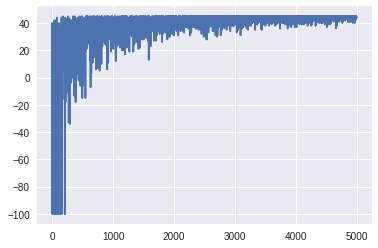

Episode lengths:


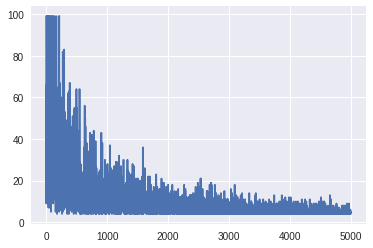

In [ ]:
print("Episode rewards:")
plt.plot(stats.episode_rewards)
plt.show()
print("Episode lengths:")
plt.plot(stats.episode_lengths)
plt.show()

In [ ]:
import pickle

pickle.dump(stats, open(experiment_dir + "/stats.p", "wb" ))

# st = pickle.load(open(experiment_dir + "/stats.p", "rb" ))

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
tf.__version__

'1.6.0'